<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/survivalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/survivalAnalysisPD

/content/drive/My Drive/Colab Notebooks/survivalAnalysisPD


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [3]:
# Import data
transaction = pd.read_parquet('transaction.parquet',
                              engine = 'pyarrow')

print(f'Total rows: {transaction.shape[0]}')
print(f'Total columns: {transaction.shape[1]}')

Total rows: 12244923
Total columns: 7


In [4]:
# Create default flag (0, 1)
condition = transaction['Aging'].ge(4)
transaction['dfFlag'] = np.where(condition, 1, 0)

# Flag inactive and write-off account
condition = ((transaction['Status'].eq(0)) |
             (transaction['writeOff'].eq(1)))
transaction['dfFlag'] = np.where(condition, np.nan, transaction['dfFlag'])

# Create year of observation
transaction['Year'] = transaction['As of month'].dt.year
transaction = transaction.drop(['As of month'], axis = 1) #Drop as of date column
transaction['Year'] = transaction['Year'].astype(np.uint16) #Convert to uint16

In [5]:
# Survival analysis for lifetime status
transaction = transaction.sort_values(by = ['AccID', 'Monthkey']) #Sort data by month
lag = transaction['Monthkey'].max() #Lag variable

# Lifetime default observed
for i in range(1, lag): #-1 for total observation because need at least 1 month to observe
  transaction[f'dfFlag{i}'] = transaction.groupby(['AccID'])['dfFlag'].shift(-i).astype(np.float32)
  print(f'Column: {transaction.columns[-1]} created')

Column: dfFlag1 created
Column: dfFlag2 created
Column: dfFlag3 created
Column: dfFlag4 created
Column: dfFlag5 created
Column: dfFlag6 created
Column: dfFlag7 created
Column: dfFlag8 created
Column: dfFlag9 created
Column: dfFlag10 created
Column: dfFlag11 created
Column: dfFlag12 created
Column: dfFlag13 created
Column: dfFlag14 created
Column: dfFlag15 created
Column: dfFlag16 created
Column: dfFlag17 created
Column: dfFlag18 created
Column: dfFlag19 created
Column: dfFlag20 created
Column: dfFlag21 created
Column: dfFlag22 created
Column: dfFlag23 created
Column: dfFlag24 created
Column: dfFlag25 created
Column: dfFlag26 created
Column: dfFlag27 created
Column: dfFlag28 created
Column: dfFlag29 created
Column: dfFlag30 created
Column: dfFlag31 created
Column: dfFlag32 created
Column: dfFlag33 created
Column: dfFlag34 created
Column: dfFlag35 created
Column: dfFlag36 created
Column: dfFlag37 created
Column: dfFlag38 created
Column: dfFlag39 created
Column: dfFlag40 created
Column: d

In [6]:
# Create ever 12-months default status
transaction['12M90DPD'] = transaction.loc[:, 'dfFlag1':'dfFlag12'].max(axis = 1)
condition = transaction['12M90DPD'].eq(1)
transaction['everDefault12'] = np.where(condition, 1, 0)
transaction['everDefault12'] = transaction['everDefault12'].astype(np.uint8)
transaction = transaction.drop(['12M90DPD'], axis = 1)

In [7]:
# Exclusion rules
# 1: Write-off observation
# 2: Selecte only active account
# 3: Exclude less than 12-months performance window
# 4: Exclude default at observation
transaction = transaction.query('writeOff != 1 & Status == 10 & Monthkey <= @lag - 12 & dfFlag != 1')

# 5: Exclude no next month performance
transaction = transaction[transaction['dfFlag1'].notnull()]

In [8]:
# Survival curves
condition = np.ma.masked_invalid(transaction.loc[:, 'dfFlag1':f'dfFlag{lag - 1}'].values) == 1
transaction['lifetimeFlag'], transaction['times'] = [np.where(np.any(condition, 1), 1, 0),
                                                     np.where(np.any(condition, 1), condition.argmax(1) + 1,
                                                              np.ma.MaskedArray.count(condition, 1))]

In [9]:
# Summary curves by year and risk grade
# Data period is from 2014 - 2019 (72 months in total)
# First default year is 2014 and the model consider 12-month performance
# Then, the latest default year will be excluded from 'observation period'
# Hence, from 2014 can be observed until month of 60
# By increasing year will be decreased in month observed by 12
# Create blank table
maxObserved = int((transaction['Year'].max() - transaction['Year'].min()) + 1) * 12
observationSummary = []

for segment in transaction['Segment'].unique():
    for aging in transaction['Aging'].unique():
        for year, time in zip(transaction['Year'].unique(), range(maxObserved, 0, -12)):
            table = pd.DataFrame(range(1, time + 1), columns = ['times'])
            table['Year'], table['Aging'], table['Segment'] = year, aging, segment
            observationSummary.append(table)

observationSummary = pd.concat(observationSummary, axis = 0)

In [10]:
# Count lifetime default observation
observationCount = transaction.groupby(['Segment', 'Aging', 'Year'], as_index = False)['AccID'].count() #Default by year
observationCount = observationCount.rename(columns = {'AccID': 'N'})

observationBad = transaction.groupby(['Segment', 'Aging', 'Year', 'times'], as_index = False)['lifetimeFlag'].sum() #Default count
observationBad = observationBad.rename(columns = {'lifetimeFlag': 'Bad'})

In [11]:
# Mapping table with data period assumption
# Merge blank table with count table
observationSummary = pd.merge(observationSummary, observationCount[['Segment', 'Aging', 'Year', 'N']],
                              how = 'left',
                              left_on = ['Segment', 'Aging', 'Year'],
                              right_on = ['Segment', 'Aging', 'Year'])

observationSummary = pd.merge(observationSummary, observationBad[['Segment', 'Aging', 'Year', 'times', 'Bad']],
                              how = 'left',
                              left_on = ['Segment', 'Aging', 'Year', 'times'],
                              right_on = ['Segment', 'Aging', 'Year', 'times']) #Merge by time observed

# Fill missing values
observationSummary['cumBad'] = observationSummary.groupby(['Segment', 'Aging', 'Year'])['Bad'].cumsum()
observationSummary['cumBad'] = observationSummary.groupby(['Segment', 'Aging', 'Year'])['cumBad'].ffill() #Remain value of bad
observationSummary = observationSummary.eval('badRate = cumBad / N') #Cumulative PD

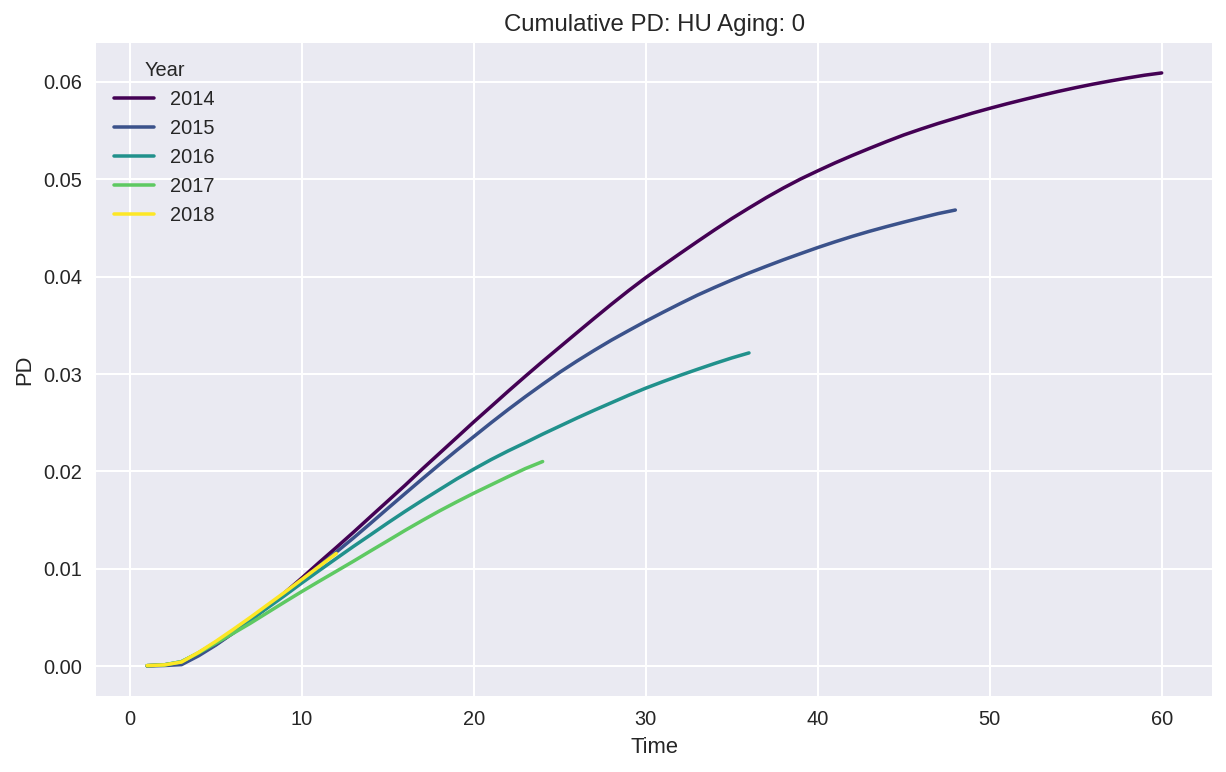

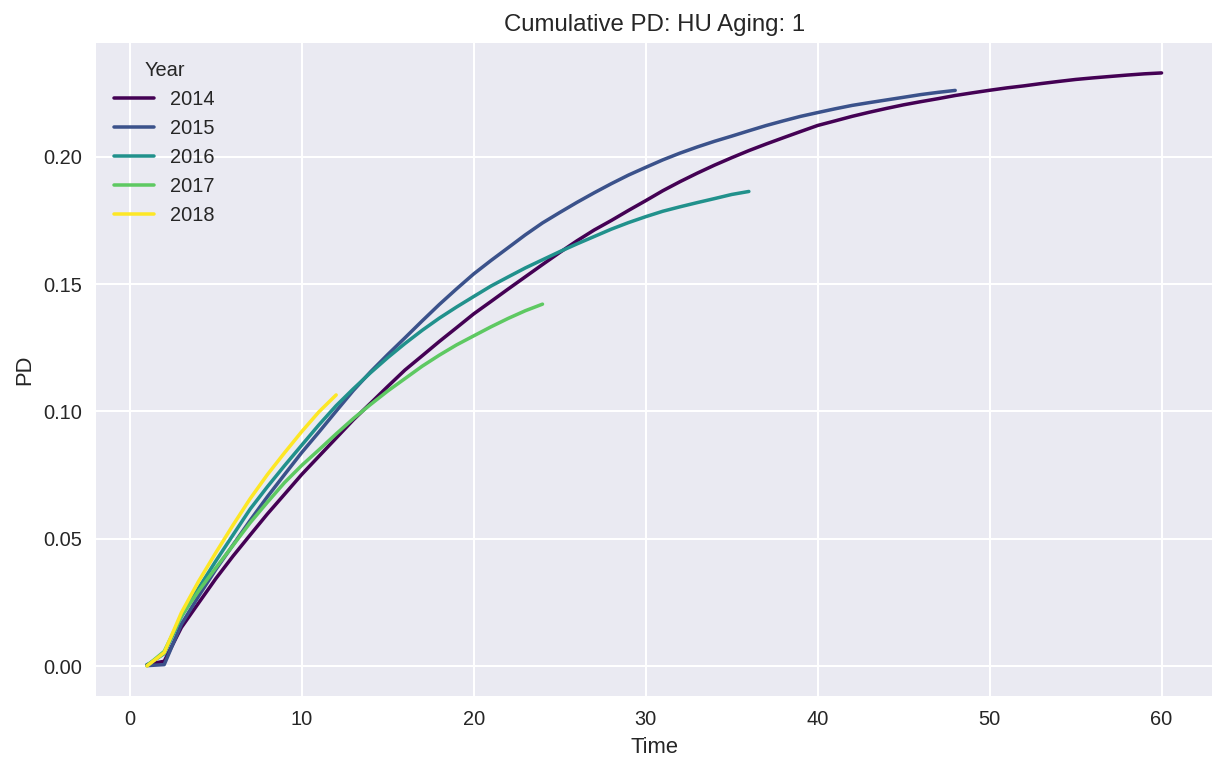

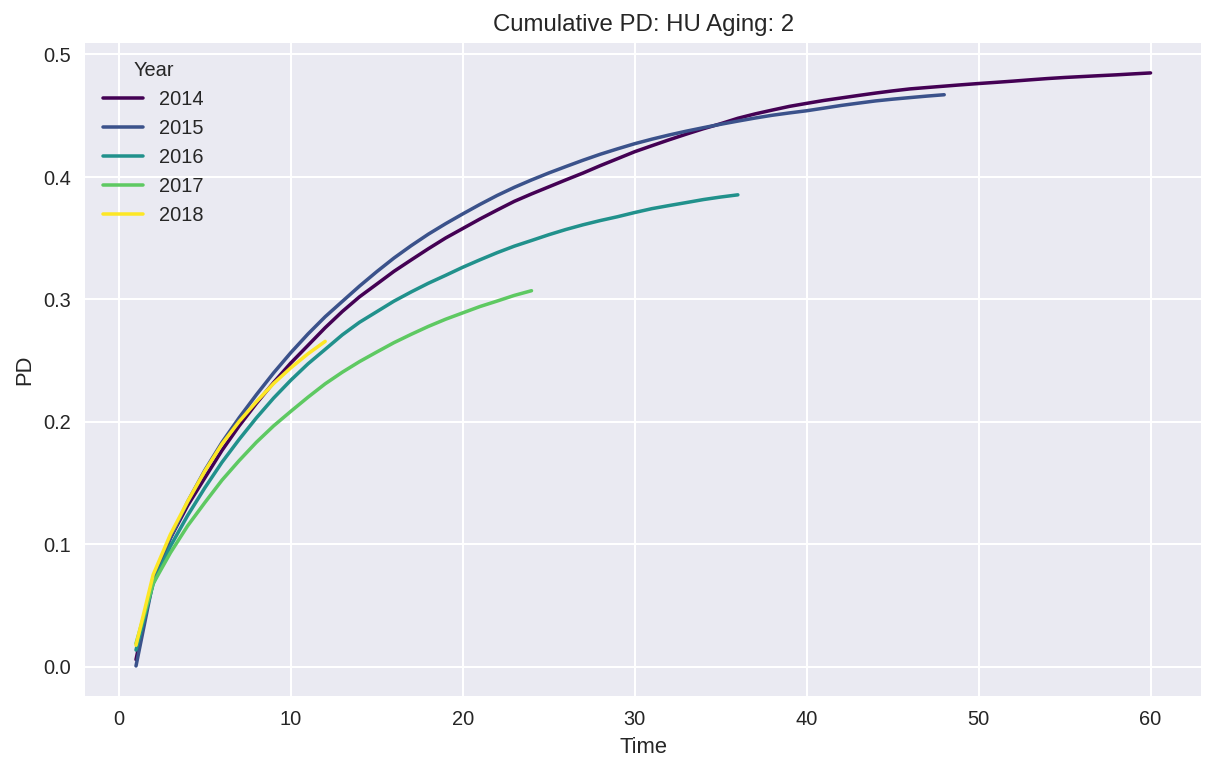

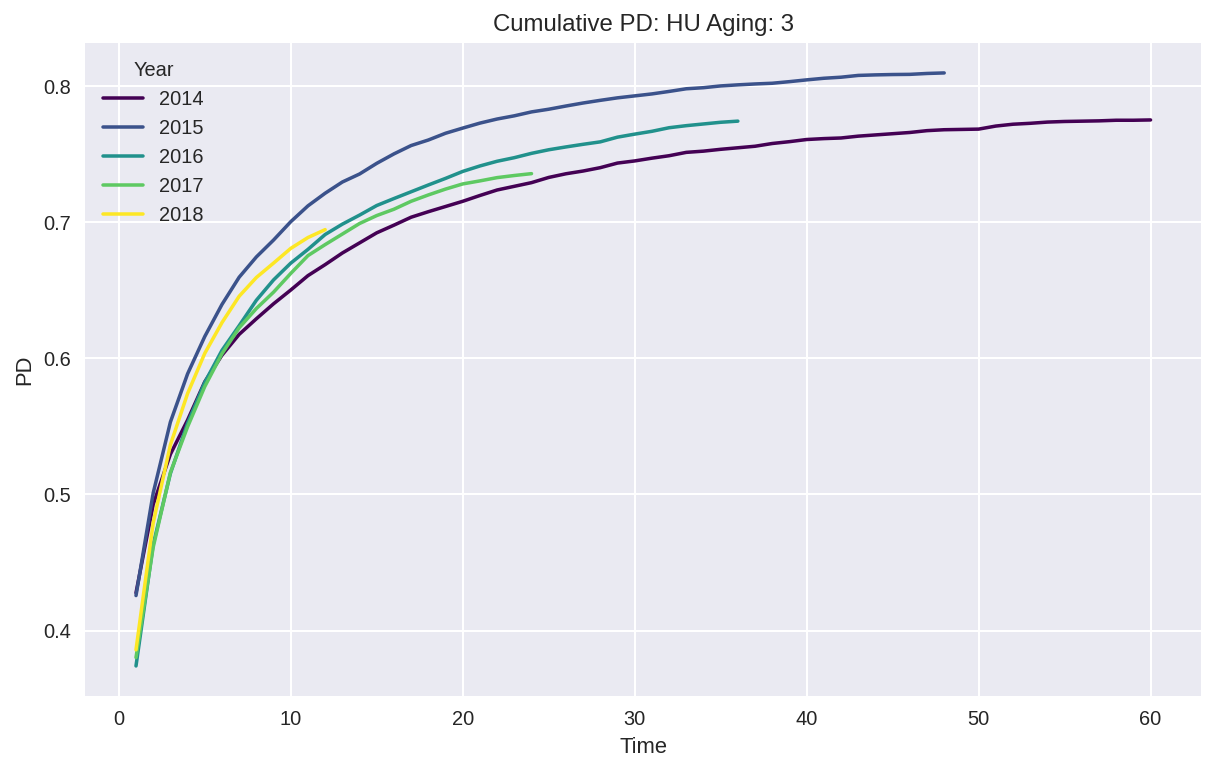

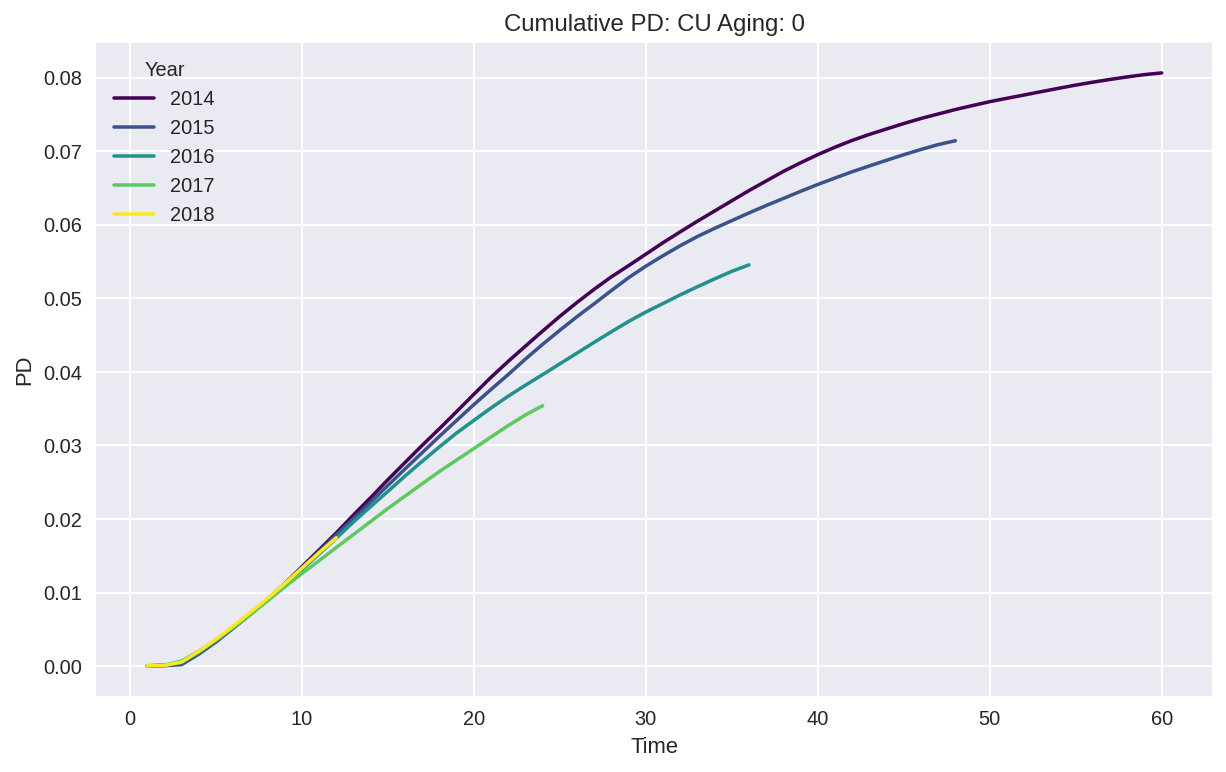

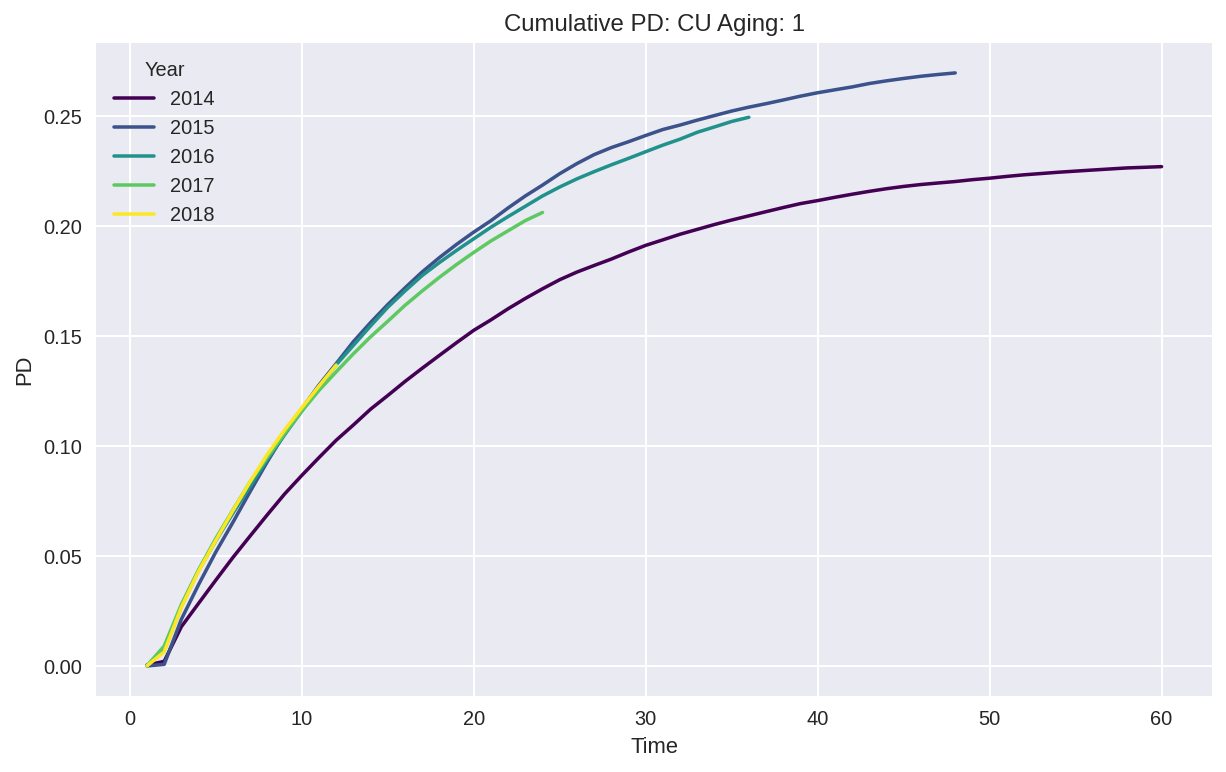

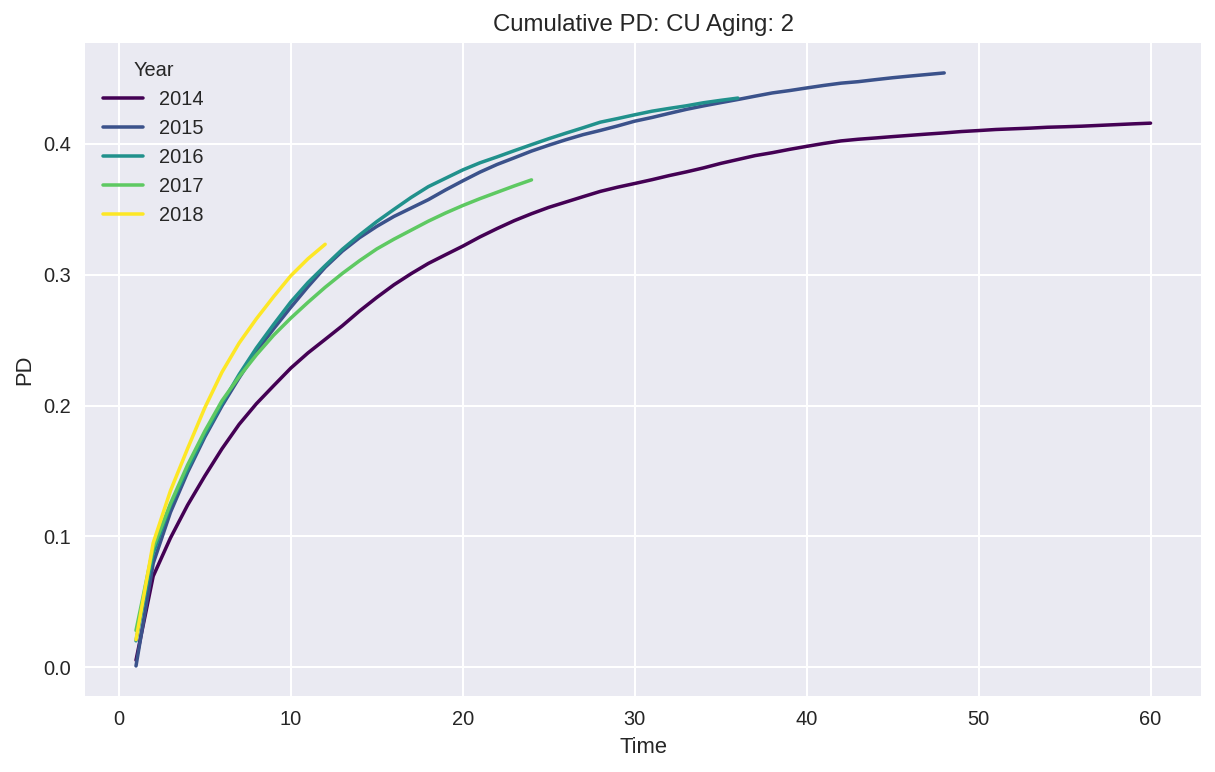

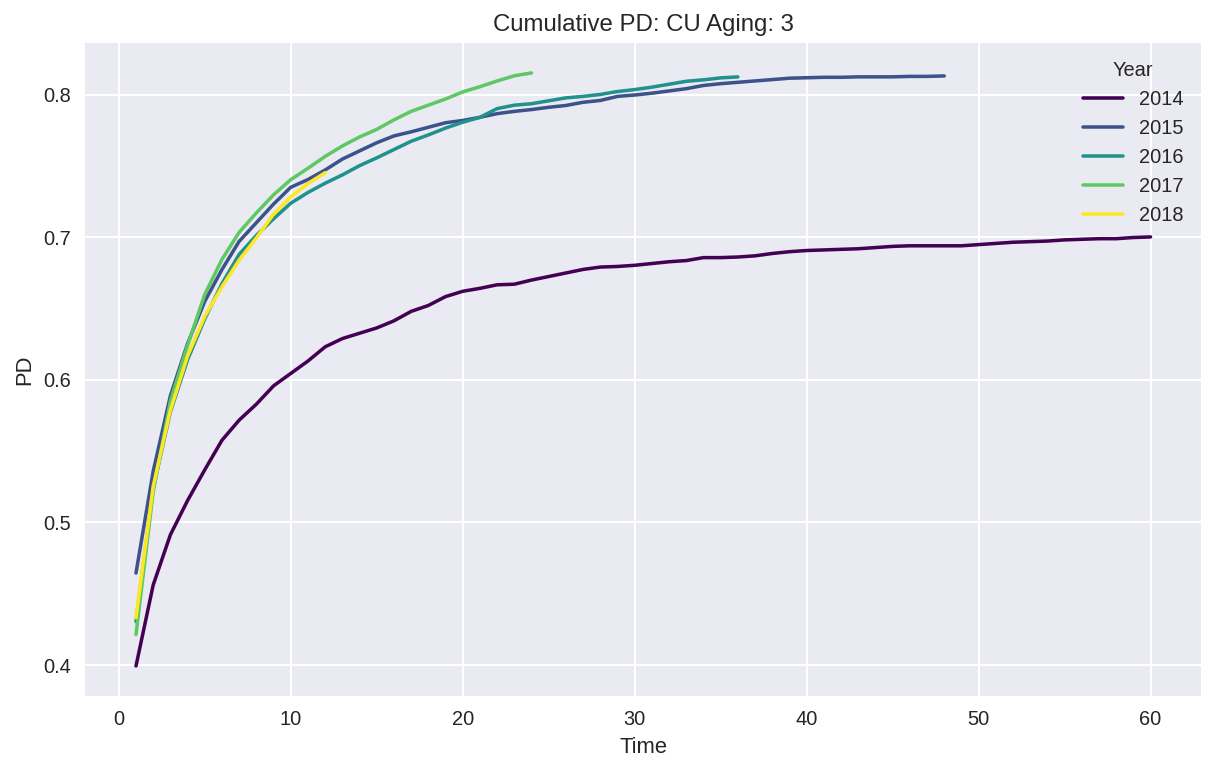

In [12]:
# Plot result
for segment in observationSummary['Segment'].unique():
  for aging in observationSummary['Aging'].unique():
    data = observationSummary[(observationSummary['Segment'] == segment) & (observationSummary['Aging'] == aging)]
    
    plt.figure(figsize = (10, 6))
    with plt.style.context('seaborn'):
      ax = sns.lineplot(x = 'times',
                        y = 'badRate',
                        data = data,
                        hue = 'Year',
                        legend = 'full',
                        palette = 'viridis',
                        ci = None)
      ax.set_title(f'Cumulative PD: {segment} Aging: {aging}')
      ax.set(xlabel = 'Time', ylabel = 'PD')
      plt.savefig(f'plot{segment}_{aging}')
      plt.show()

In [13]:
# Pivot table for summary
observationPivot = pd.pivot_table(observationSummary,
                                  values = 'badRate',
                                  index = ['Segment', 'Aging', 'Year', 'N'],
                                  columns = ['times']).reset_index()
observationPivot.head(5)

times,Segment,Aging,Year,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,CU,0,2014,218263,0.000032,0.000133,0.000353,0.001874,0.003468,0.005200,0.007065,0.009053,0.011202,0.013511,0.015802,0.018116,0.020553,0.022913,0.025346,0.027691,0.030028,0.032291,0.034619,0.036965,0.039278,0.041441,0.043516,0.045564,0.047562,0.049454,0.051250,0.052936,0.054457,0.056010,0.057577,0.059048,0.060496,0.061884,0.063277,0.064661,0.065971,0.067267,0.068440,0.069545,0.070562,0.071487,0.072298,0.073040,0.073778,0.074465,0.075075,0.075684,0.076225,0.076751,0.07721,0.077659,0.078117,0.078566,0.079006,0.079404,0.079775,0.080119,0.08043,0.08066
1,CU,0,2015,255698,0.000023,0.000063,0.000199,0.001623,0.003277,0.005143,0.007040,0.009108,0.011166,0.013375,0.015589,0.017865,0.020047,0.022311,0.024568,0.026817,0.029034,0.031252,0.033411,0.035558,0.037626,0.039648,0.041752,0.043759,0.045667,0.047521,0.049277,0.051072,0.052820,0.054381,0.055808,0.057165,0.058413,0.059527,0.060575,0.061623,0.062629,0.063591,0.064561,0.065491,0.066367,0.067224,0.068010,0.068784,0.069539,0.070251,0.070916,0.071436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CU,0,2016,299541,0.000037,0.000080,0.000484,0.001819,0.003479,0.005288,0.007174,0.009057,0.011044,0.013130,0.015253,0.017403,0.019600,0.021697,0.023756,0.025853,0.027866,0.029816,0.031702,0.033411,0.035104,0.036709,0.038195,0.039637,0.041106,0.042565,0.044034,0.045466,0.046868,0.048144,0.049302,0.050481,0.051582,0.052654,0.053679,0.054560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CU,0,2017,325631,0.000049,0.000126,0.000694,0.002024,0.003535,0.005239,0.007008,0.008869,0.010761,0.012588,0.014329,0.016132,0.017894,0.019666,0.021438,0.023124,0.024807,0.026469,0.028026,0.029573,0.031161,0.032706,0.034152,0.035411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CU,0,2018,326584,0.000043,0.000101,0.000545,0.001990,0.003647,0.005447,0.007288,0.009207,0.011213,0.013320,0.015423,0.017456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Export result
observationPivot.to_csv('PDCurves.csv', index = 0)

In [15]:
# Check 12-months observation
unbiasCount = transaction.groupby(['Segment', 'Aging'], as_index = False)['AccID'].count() # Default by aging
unbiasCount = unbiasCount.rename(columns = {'AccID': 'N'})
unbiasCount['Bad'] = list(transaction.groupby(['Segment', 'Aging'])['everDefault12'].sum())
unbiasCount.head(10)

,Segment,Aging,N,Bad
0,CU,0,1425717,24689.0
1,CU,1,178034,23044.0
2,CU,2,73212,21677.0
3,CU,3,14363,10429.0
4,HU,0,4232680,47504.0
5,HU,1,423105,41338.0
6,HU,2,164827,43319.0
7,HU,3,30127,20930.0


In [16]:
# Create montlhy ODR
monthlyODR = transaction.groupby(['Segment', 'Monthkey'], as_index = False)['AccID'].count() # Default by month
monthlyODR = monthlyODR.rename(columns = {'AccID': 'N'})
monthlyODR['Bad'] = list(transaction.groupby(['Segment', 'Monthkey'])['everDefault12'].sum())
monthlyODR.head(10)

,Segment,Monthkey,N,Bad
0,CU,1,21556,815.0
1,CU,2,21794,885.0
2,CU,3,21911,920.0
3,CU,4,22128,960.0
4,CU,5,22115,989.0
5,CU,6,22266,1037.0
6,CU,7,22376,1033.0
7,CU,8,22473,1069.0
8,CU,9,22712,1137.0
9,CU,10,23166,1188.0


In [17]:
# Export result
monthlyODR.to_csv('monthlyODR.csv', index = 0)

In [18]:
# Create montlhy ODR by risk grade
monthlyODRAging = transaction.groupby(['Segment', 'Aging', 'Monthkey'], as_index = False)['AccID'].count() # Default by month
monthlyODRAging = monthlyODRAging.rename(columns = {'AccID': 'N'})
monthlyODRAging['Bad'] = list(transaction.groupby(['Segment', 'Aging', 'Monthkey'])['everDefault12'].sum())
monthlyODRAging.head(10)

,Segment,Aging,Monthkey,N,Bad
0,CU,0,1,17546,288.0
1,CU,0,2,16796,249.0
2,CU,0,3,17693,298.0
3,CU,0,4,17821,282.0
4,CU,0,5,17951,314.0
5,CU,0,6,18158,336.0
6,CU,0,7,18609,369.0
7,CU,0,8,18032,344.0
8,CU,0,9,18516,378.0
9,CU,0,10,18933,366.0


In [19]:
# Export result
monthlyODRAging.to_csv('monthlyODRAging.csv', index = 0)